In [ ]:
# Testing purposes

from antlr4 import *
from SQLiteLexer import SQLiteLexer
from SQLiteParser import SQLiteParser
from SQLiteParserListener import SQLiteParserListener
import json
import os
import glob
from pathlib import Path
from discopy.utils import dumps
this_folder = os.path.abspath(os.getcwd())

path = this_folder + "\\join-order-benchmark-queries\\7c.sql"
#path = this_folder + "\\simple_examples\\sql3.sql"

input_stream = FileStream(path)
lexer = SQLiteLexer(input_stream)
stream = CommonTokenStream(lexer)
parser = SQLiteParser(stream)
tree = parser.parse()

print("Whole parse tree: ")
print(tree.toStringTree(recog=parser))

base_name = "sql3"
input_stream = FileStream(path)
lexer = SQLiteLexer(input_stream)
stream = CommonTokenStream(lexer)
parser = SQLiteParser(stream)
tree = parser.parse()
walker = ParseTreeWalker()
listener = SQLiteParserListener(parser)
walker.walk(listener, tree)
diagram = listener.get_final_diagram()
diagram.draw(figsize=(100, 100), path = this_folder + "\\" + base_name + ".png")
with open(this_folder + "\\" + base_name + ".json", 'w') as outfile:
    json.dump(dumps(diagram), outfile)

In [1]:
from tree import Tree
from discopy import Ty, Box

tree = Tree('parse', Ty('statement'), 1)
#subtree = Tree('sql_stmt', Ty('statement'), 1)
#tree.append_to_tree(subtree)
#tree.print_tree()

In [2]:
select_clause_children_count = 2
from_clause_children_count = 5
where_clause_children_count = 1 # This is always 1 based on the railroad diagrams


# SELECT, FROM, WHERE keyword leaves
select_keyword_node = Tree('SELECT', Ty('keyword'), 0)
from_keyword_node = Tree('FROM', Ty('keyword'), 0)
where_keyword_node = Tree('WHERE', Ty('keyword'), 0)

# select_clause, from_clause and where_clauses which are partially initialized
select_clause = Tree('select_clause', Ty('select_clause'), select_clause_children_count, [select_keyword_node])
from_clause = Tree('from_clause', Ty('from_clause'), from_clause_children_count, [from_keyword_node])
where_clause = Tree('where_clause', Ty('where_clause'), where_clause_children_count, [where_keyword_node])
print(select_clause.is_full())
select_core_tree = Tree('select_core', Ty('statement'), 3, [select_clause, from_clause, where_clause])

tree.append_to_tree(select_core_tree)

expr_tree1 = Tree('expr', Ty('expr'), 2)
success = tree.append_to_tree(expr_tree1)


name = 'MIN'
node = Tree(name, Ty('function_name'), 0)
tree.append_to_tree(node)

#expr_tree = Tree('expr', Ty('expr'), 2)
#success = tree.append_to_tree(expr_tree)

name = 'table1'
node = Tree(name, Ty('table_name'), 0)
tree.append_to_tree(node)

print('Select full: ', select_clause.is_full())
print("First expr full: ", expr_tree1.is_full())

False
Select full:  False
First expr full:  False


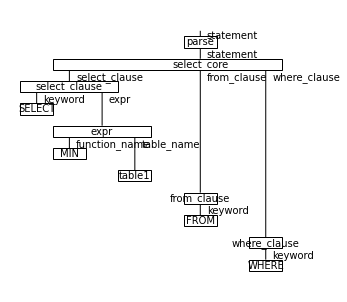

In [3]:
diagram = tree.get_diagram()
diagram.draw(figsize=(4, 4))
#tree.print_tree()

The following code removes cups that connect to boxes whose domain is empty type.

In [1]:
def remove_leaf_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        #print('Box and offset: ', box, offset)
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            #print('len(diags[i].cod) - 1: ', len(diags[i].cod) - 1)
            while off > len(diags[i].cod) - 1:
                #print('In loop')
                off -= len(diags[i].cod)
                i += 1
            if len(diags) > 1:
                left, right = diags[i:i+2]
                #print(diags)
                #print('left: ', left)
                #print('right: ', right)

                if len(left.cod) == 1:
                    new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
                else:
                    if len(right.cod) == 1:
                        new_diag = left >> Id(s) @ right.l.dagger() @ Id(left.cod[offset + 1:])
                    else:
                        # The following code does not change the diagram now
                        # This case will be handled after all leaf cups have been removed
                        new_diag = left >> Id(s) @ right @ Id(left.cod[1:]) >> box @ Id(right.cod[1:]) @ Id(left.cod[1:])

                diags[i:i+2] = [new_diag]
            else:
                #print(box)
                diags[0] = diags[0] >> Id(s) @ Id(diags[0].cod[:offset - 1]) @ box @ Id(diags[0].cod[offset + 1:])
                #print(diags)
                #print('what what')

    assert len(diags) == 1
    return diags[0]